In [6]:
schema_calif = {
    'cod_semestre': pl.String,
    'cod_facultad': pl.Int64,
    'cod_escuela': pl.Int64,
    'cod_plan': pl.String,
    'cod_asignatura': pl.String,
    'cod_alumno': pl.String,
    'val_calific_final': pl.Int64
}

schema_rep = {
    'cod_facultad': pl.Int64,
    'cod_escuela': pl.Int64,
    'cod_semestre': pl.String,
    'cod_alumno': pl.String,
    'cod_plan': pl.String,
    'cod_asignatura': pl.String,
    'asignatura': pl.String,
    'num_rep': pl.Int64
}

schema_tutorias = {
    'cod_alumno': pl.String,
    'cod_semestre': pl.String,
    'cod_facultad': pl.Int64,
    'cod_escuela': pl.Int64,
    'num_res_autoriza': pl.String,
    'cod_tipo_autorizacion': pl.String
}


In [7]:
import polars as pl

anios = ["2019", "2020"]

# ---- CALIFICACIONES ----
df_calif = pl.concat(
    [
        pl.read_excel(
            "calificaciones.xlsx",
            sheet_name=anio,
            schema_overrides=schema_calif
        )
        for anio in anios
    ],
    how="vertical"
).drop(["cod_plan"])


# ---- REPITENCIAS ----
df_rep = pl.concat(
    [
        pl.read_excel(
            "repitencias.xlsx",
            sheet_name=anio,
            schema_overrides=schema_rep
        )
        for anio in anios
    ],
    how="vertical"
).drop(["cod_plan"])


# ---- TUTORÍAS ----
df_tutorias = pl.concat(
    [
        pl.read_excel(
            "tutorias.xlsx",
            sheet_name=anio,
            schema_overrides=schema_tutorias
        )
        for anio in anios
    ],
    how="vertical"
).drop(["num_res_autoriza", "cod_tipo_autorizacion"])


In [8]:
df_features_calif = (
    df_calif
    .filter(pl.col("val_calific_final").is_between(0, 20))
    .with_columns(
        is_aprobado = pl.col("val_calific_final") >= 11
    )
    .group_by("cod_alumno")
    .agg(
        promedio_calif = pl.col("val_calific_final").mean(),
        std_calif = pl.col("val_calific_final").std(),
        num_asignaturas = pl.col("cod_asignatura").n_unique(),
        tasa_aprobacion = pl.col("is_aprobado").mean(),
        num_semestres_activos = pl.col("cod_semestre").n_unique()
    )
)

df_features_calif

cod_alumno,promedio_calif,std_calif,num_asignaturas,tasa_aprobacion,num_semestres_activos
str,f64,f64,u32,f64,u32
"""14020150""",15.444444,2.650996,9,1.0,1
"""17150071""",13.782609,2.411271,23,1.0,4
"""13010239""",18.75,1.258306,4,1.0,1
"""11070010""",13.0,1.414214,2,1.0,1
"""18120066""",14.291667,2.45798,24,0.958333,4
…,…,…,…,…,…
"""18110386""",15.071429,2.089277,28,1.0,4
"""12150252""",13.333333,1.527525,3,1.0,1
"""16170036""",12.833333,5.001449,22,0.833333,4


In [9]:
df_features_rep = (
    df_rep
    .group_by("cod_alumno")
    .agg(
        total_repitencias = pl.col("num_rep").sum(),
        max_rep_asignatura = pl.col("num_rep").max()
    )
)

df_features_rep

cod_alumno,total_repitencias,max_rep_asignatura
str,i64,i64
"""18100092""",6,2
"""15200135""",1,1
"""14170176""",3,2
"""15150306""",12,2
"""19110181""",1,1
…,…,…
"""15150403""",48,3
"""17190122""",4,1
"""18010069""",5,1


In [10]:
df_features_tutorias = (
    df_tutorias
    .group_by("cod_alumno")
    .agg(
        num_tutorias = pl.col("cod_alumno").count()
    )
)

df_features_tutorias

cod_alumno,num_tutorias
str,u32
"""16140105""",2
"""15160137""",3
"""16030318""",1
"""08170013""",3
"""07190102""",4
…,…
"""17020266""",1
"""11140387""",1
"""17190190""",1


In [11]:
df_final = (
    df_features_calif
    .join(df_features_rep, on="cod_alumno", how="left")
    .join(df_features_tutorias, on="cod_alumno", how="left")
    .fill_null(0)
)

df_final

cod_alumno,promedio_calif,std_calif,num_asignaturas,tasa_aprobacion,num_semestres_activos,total_repitencias,max_rep_asignatura,num_tutorias
str,f64,f64,u32,f64,u32,i64,i64,u32
"""14020150""",15.444444,2.650996,9,1.0,1,0,0,0
"""17150071""",13.782609,2.411271,23,1.0,4,0,0,0
"""13010239""",18.75,1.258306,4,1.0,1,0,0,0
"""11070010""",13.0,1.414214,2,1.0,1,4,2,1
"""18120066""",14.291667,2.45798,24,0.958333,4,0,0,0
…,…,…,…,…,…,…,…,…
"""18110386""",15.071429,2.089277,28,1.0,4,1,1,0
"""12150252""",13.333333,1.527525,3,1.0,1,0,0,0
"""16170036""",12.833333,5.001449,22,0.833333,4,7,1,0


In [12]:
df_contexto = (
    df_calif
    .select(["cod_alumno", "cod_facultad", "cod_escuela"])
    .group_by("cod_alumno")
    .agg(
        facultad_principal = pl.col("cod_facultad").mode().cast(pl.Int32).first(),
        escuela_principal = pl.col("cod_escuela").mode().cast(pl.Int32).first()
    )
)

In [13]:
df_final = df_final.join(df_contexto, on="cod_alumno", how="left")

In [14]:
df_final

cod_alumno,promedio_calif,std_calif,num_asignaturas,tasa_aprobacion,num_semestres_activos,total_repitencias,max_rep_asignatura,num_tutorias,facultad_principal,escuela_principal
str,f64,f64,u32,f64,u32,i64,i64,u32,i32,i32
"""14020150""",15.444444,2.650996,9,1.0,1,0,0,0,2,2
"""17150071""",13.782609,2.411271,23,1.0,4,0,0,0,15,4
"""13010239""",18.75,1.258306,4,1.0,1,0,0,0,1,1
"""11070010""",13.0,1.414214,2,1.0,1,4,2,1,7,1
"""18120066""",14.291667,2.45798,24,0.958333,4,0,0,0,12,3
…,…,…,…,…,…,…,…,…,…,…
"""18110386""",15.071429,2.089277,28,1.0,4,1,1,0,11,1
"""12150252""",13.333333,1.527525,3,1.0,1,0,0,0,15,3
"""16170036""",12.833333,5.001449,22,0.833333,4,7,1,0,17,1


In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Aseguramos que no haya nulos antes de pasar a Pandas para evitar errores en el Encoder
# Rellenamos numéricos con 0 y categóricos con un valor por defecto si fuera necesario
df_final_clean = df_final.fill_null(0) 

# Conversión a Pandas (requiere pyarrow instalado y kernel reiniciado)
df_pd = df_final_clean.to_pandas()

features_df = df_pd.drop(columns=["cod_alumno"])

numeric_features = [
    'promedio_calif', 'std_calif', 'num_asignaturas', 'tasa_aprobacion', 
    'num_semestres_activos', 'total_repitencias', 'max_rep_asignatura', 
    'num_tutorias'
]
categorical_features = ['facultad_principal', 'escuela_principal']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

X_scaled = preprocessor.fit_transform(features_df)
# filepath: c:\Users\mauri\OneDrive\Desktop\CICLO 8\mineria de datos\minieria.ipynb
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Aseguramos que no haya nulos antes de pasar a Pandas para evitar errores en el Encoder
# Rellenamos numéricos con 0 y categóricos con un valor por defecto si fuera necesario
df_final_clean = df_final.fill_null(0) 

# Conversión a Pandas (requiere pyarrow instalado y kernel reiniciado)
df_pd = df_final_clean.to_pandas()

features_df = df_pd.drop(columns=["cod_alumno"])

numeric_features = [
    'promedio_calif', 'std_calif', 'num_asignaturas', 'tasa_aprobacion', 
    'num_semestres_activos', 'total_repitencias', 'max_rep_asignatura', 
    'num_tutorias'
]
categorical_features = ['facultad_principal', 'escuela_principal']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

X_scaled = preprocessor.fit_transform(features_df)

In [16]:
df = pd.DataFrame(X_scaled)
df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.555050,0.038683,-0.750054,0.557352,-1.644636,-0.446489,-0.709473,-0.358012
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.041316,-0.110156,0.999834,0.557352,0.995737,-0.446489,-0.709473,-0.358012
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.576919,-0.826005,-1.375014,0.557352,-1.644636,-0.446489,-0.709473,-0.358012
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.200617,-0.729206,-1.624998,0.557352,-1.644636,0.117491,1.224688,0.668513
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.198684,-0.081155,1.124826,0.367159,0.995737,-0.446489,-0.709473,-0.358012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.439738,-0.310074,1.624794,0.557352,0.995737,-0.305494,0.257607,-0.358012
34177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.097572,-0.658853,-1.500006,0.557352,-1.644636,-0.446489,-0.709473,-0.358012
34178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.252140,1.498025,0.874842,-0.203420,0.995737,0.540476,0.257607,-0.358012
34179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.047383,0.349130,-0.000102,-1.625733,0.995737,0.681471,0.257607,-0.358012


In [17]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

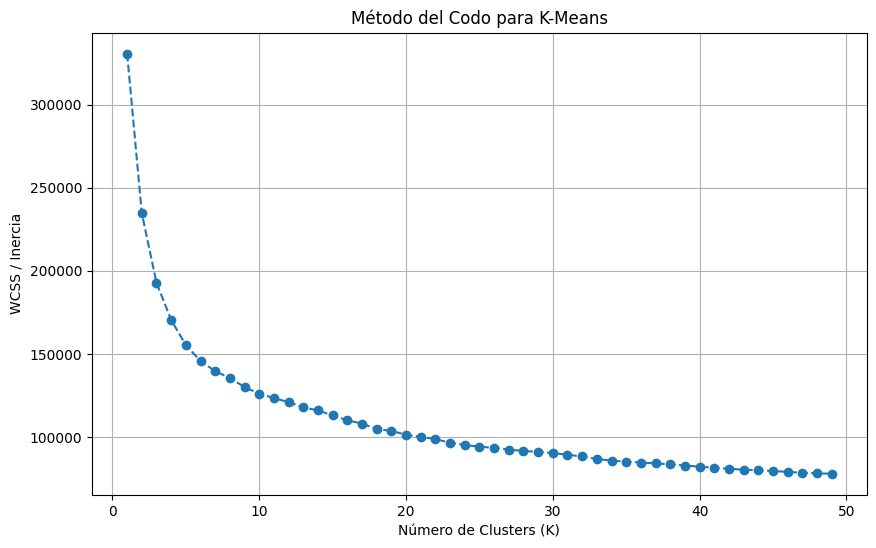

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 50), wcss, marker='o', linestyle='--')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS / Inercia')
plt.grid(True)
plt.show()

In [19]:
K_optimo = 5
kmeans_model = KMeans(n_clusters=K_optimo, random_state=42, n_init='auto')
clusters_kmeans = kmeans_model.fit_predict(X_scaled)

<Figure size 1000x800 with 0 Axes>

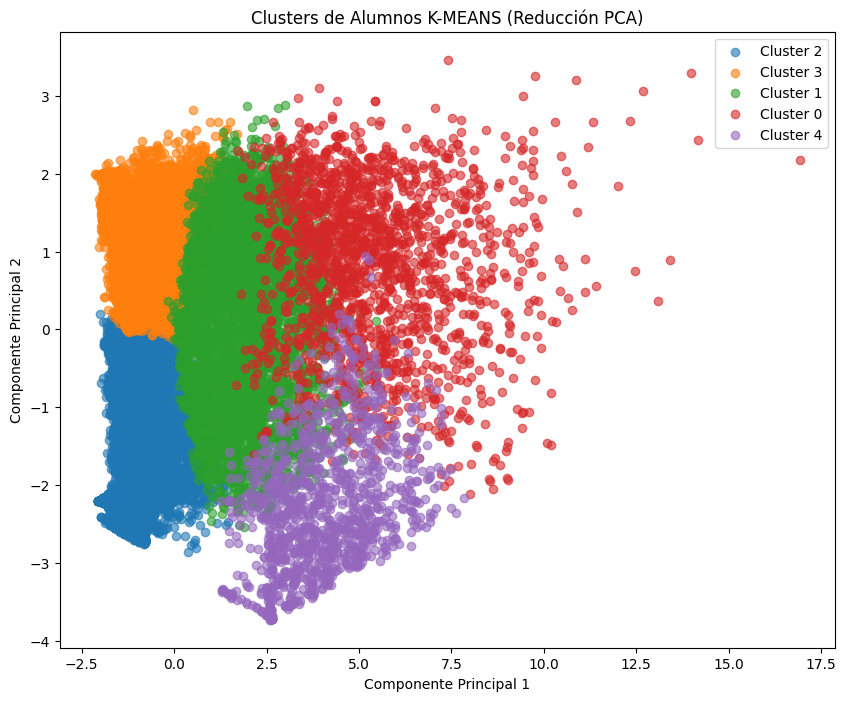

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
df_pca['Cluster'] = clusters_kmeans

plt.figure(figsize=(10,8))

plt.figure(figsize=(10, 8))
for cluster in df_pca['Cluster'].unique():
    subset = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(
        subset['PC1'], 
        subset['PC2'], 
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('Clusters de Alumnos K-MEANS (Reducción PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import silhouette_score

silhouette_avg_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print(f"Coeficiente de Silueta (KMeans): {silhouette_avg_kmeans:.3f}")

Coeficiente de Silueta (KMeans): 0.241


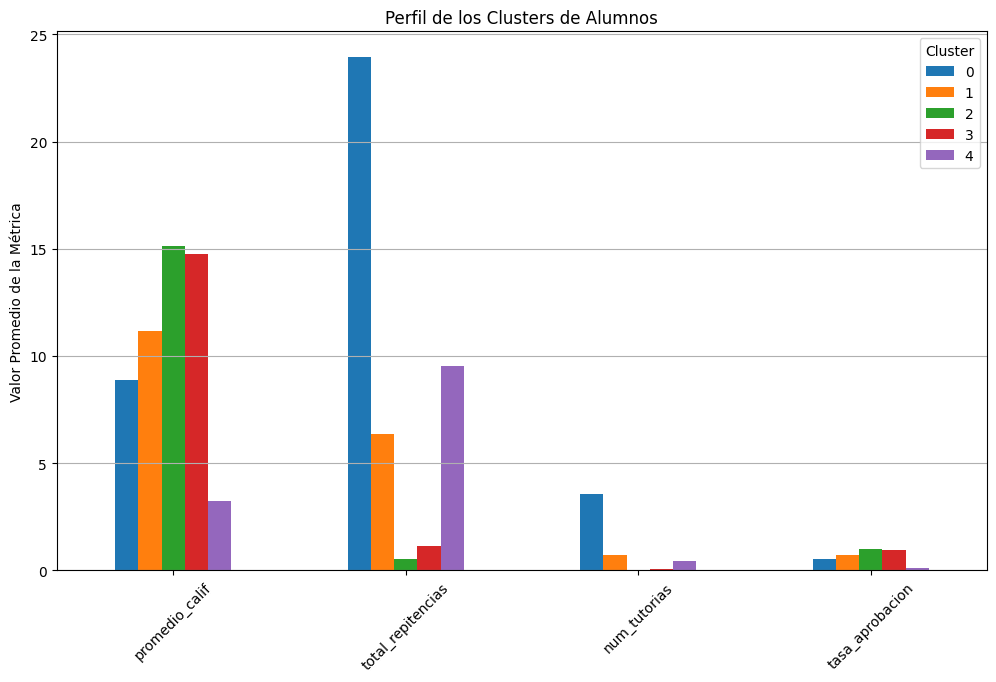

In [22]:
df_pd['Cluster'] = clusters_kmeans

profile_df = df_pd.groupby('Cluster')[['promedio_calif', 'total_repitencias', 'num_tutorias', 'tasa_aprobacion']].mean()

profile_df.T.plot(kind='bar', figsize=(12, 7))
plt.title('Perfil de los Clusters de Alumnos')
plt.ylabel('Valor Promedio de la Métrica')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.show()

In [23]:
from sklearn.cluster import DBSCAN

eps_optimo = 0.3 # 0.5 
min_samples_optimo = 10 

dbscan_model = DBSCAN(eps=eps_optimo, min_samples=min_samples_optimo)
clusters_dbscan = dbscan_model.fit_predict(X_scaled)

<Figure size 1000x800 with 0 Axes>

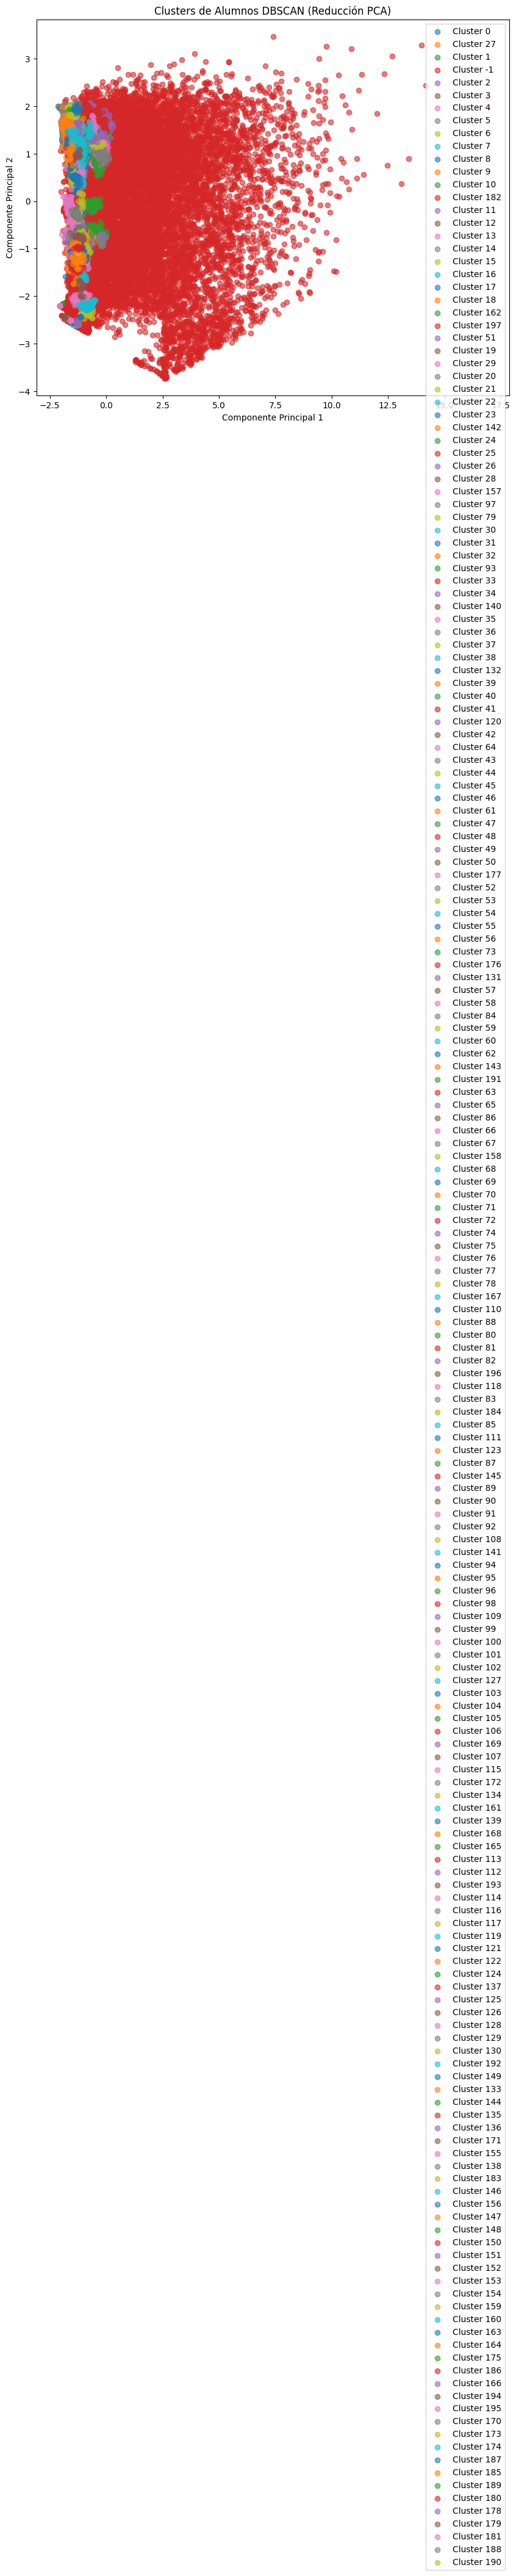

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
df_pca['Cluster'] = clusters_dbscan

plt.figure(figsize=(10,8))

plt.figure(figsize=(10, 8))
for cluster in df_pca['Cluster'].unique():
    subset = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(
        subset['PC1'], 
        subset['PC2'], 
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('Clusters de Alumnos DBSCAN (Reducción PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

In [25]:
non_noise_indices = clusters_dbscan != -1
if np.unique(clusters_dbscan[non_noise_indices]).size > 1:
    silhouette_avg_dbscan = silhouette_score(
        X_scaled[non_noise_indices], 
        clusters_dbscan[non_noise_indices]
    )
    print(f"Coeficiente de Silueta (DBSCAN - sin ruido): {silhouette_avg_dbscan:.3f}")
else:
    print("DBSCAN no encontró suficientes clusters (>1) para calcular la Silueta.")

Coeficiente de Silueta (DBSCAN - sin ruido): 0.585


### ANALISIS DE CLUSTER CON KPROTOTYPES

### EDA

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
features_df.head()

,promedio_calif,std_calif,num_asignaturas,tasa_aprobacion,num_semestres_activos,total_repitencias,max_rep_asignatura,num_tutorias,facultad_principal,escuela_principal
0,15.444444,2.650996,9,1.000000,1,0,0,0,2,2
1,13.782609,2.411271,23,1.000000,4,0,0,0,15,4
2,18.750000,1.258306,4,1.000000,1,0,0,0,1,1
3,13.000000,1.414214,2,1.000000,1,4,2,1,7,1
4,14.291667,2.457980,24,0.958333,4,0,0,0,12,3


In [28]:
features_df.columns

Index(['promedio_calif', 'std_calif', 'num_asignaturas', 'tasa_aprobacion',
       'num_semestres_activos', 'total_repitencias', 'max_rep_asignatura',
       'num_tutorias', 'facultad_principal', 'escuela_principal'],
      dtype='object')

In [29]:
numericas = ['promedio_calif', 'std_calif', 'num_asignaturas', 'tasa_aprobacion',
       'num_semestres_activos', 'total_repitencias', 'max_rep_asignatura',
       'num_tutorias'] # , 'facultad_principal', 'escuela_principal'

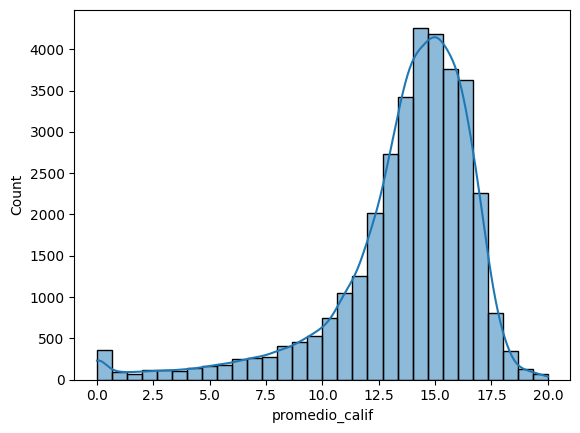

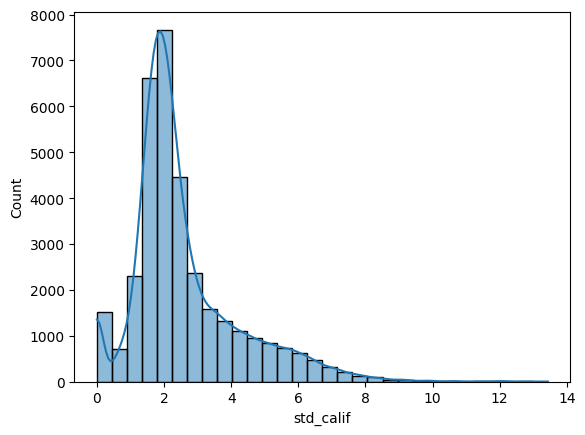

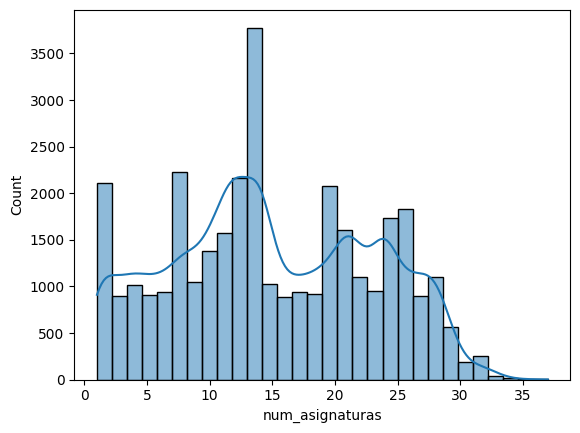

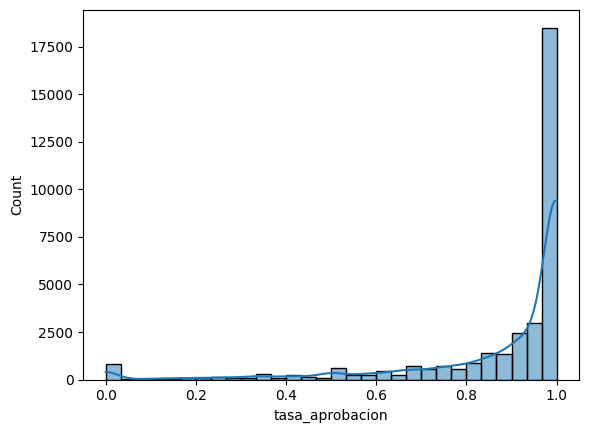

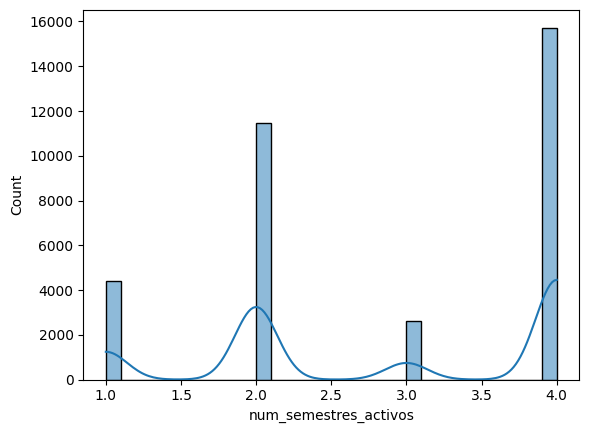

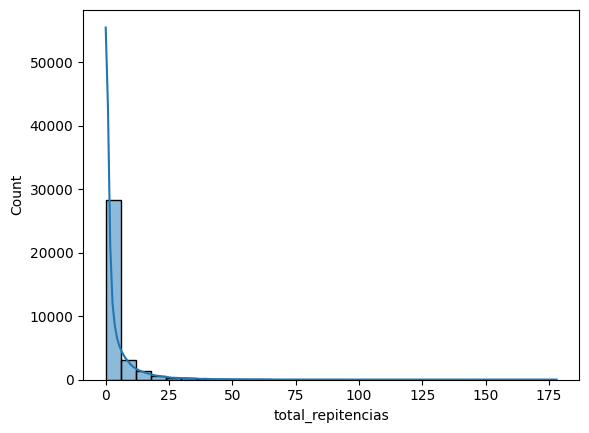

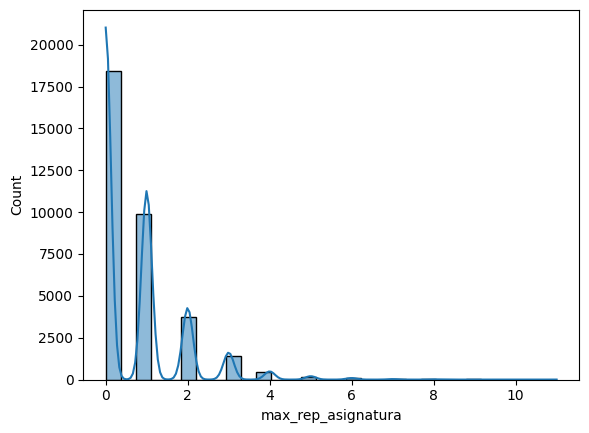

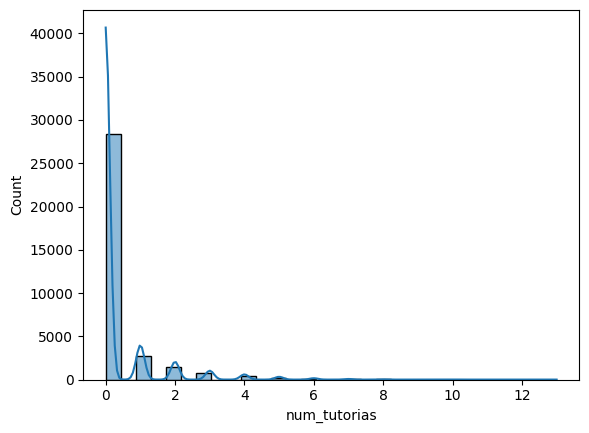

In [30]:
for col in numericas:
    sns.histplot(features_df[col], kde=True, bins=30)
    plt.show()

In [31]:
from sklearn.preprocessing import RobustScaler
numeric_features = [
    'promedio_calif', 'std_calif', 'num_asignaturas', 'tasa_aprobacion', 
    'num_semestres_activos', 'total_repitencias', 'max_rep_asignatura', 
    'num_tutorias'
]
categorical_features = ['facultad_principal', 'escuela_principal']

# SOLO escalamos los numéricos, las categorías las dejamos pasar igual ('passthrough')
preprocessor_kproto = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features) 
    ]
)

X_prepared = preprocessor_kproto.fit_transform(features_df)

In [32]:
X_scaled

array([[ 0.        ,  1.        ,  0.        , ..., -0.44648892,
        -0.70947349, -0.35801165],
       [ 0.        ,  0.        ,  0.        , ..., -0.44648892,
        -0.70947349, -0.35801165],
       [ 1.        ,  0.        ,  0.        , ..., -0.44648892,
        -0.70947349, -0.35801165],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.54047594,
         0.25760712, -0.35801165],
       [ 0.        ,  0.        ,  0.        , ...,  0.68147093,
         0.25760712, -0.35801165],
       [ 0.        ,  0.        ,  1.        , ..., -0.44648892,
        -0.70947349, -0.35801165]], shape=(34181, 38))

In [33]:
from kmodes.kprototypes import KPrototypes

K=3 procesado. Costo: 212721.94
K=4 procesado. Costo: 187147.96
K=5 procesado. Costo: 164337.88


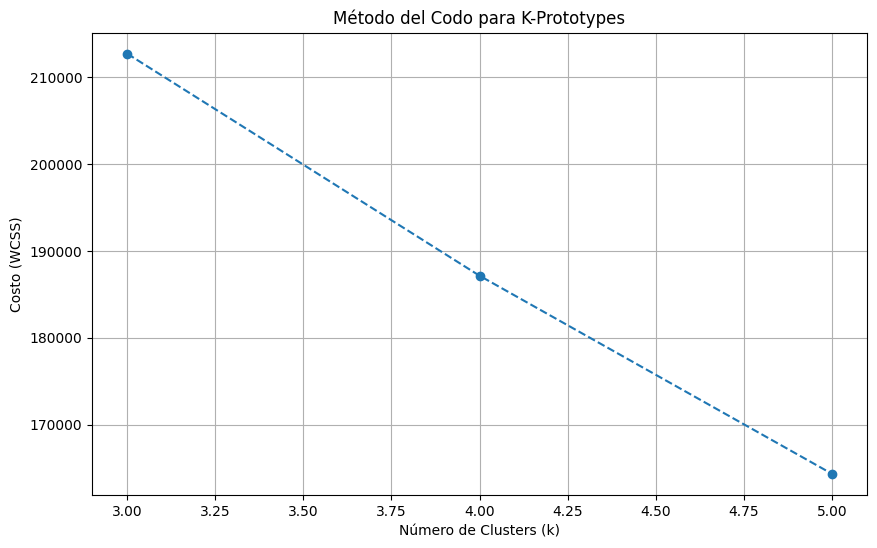

In [35]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

wcss = []
K_range = range(3, 6)

for k in K_range:
    kpro = KPrototypes(n_clusters=k, init='Huang', n_init=10, random_state=42)
    
    # Pasamos la matriz mixta y los índices categóricos correctos
    kpro.fit(X_prepared, categorical=[8,9])
    
    wcss.append(kpro.cost_)
    print(f"K={k} procesado. Costo: {kpro.cost_:.2f}")

# Graficar
plt.figure(figsize=(10,6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Método del Codo para K-Prototypes')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Costo (WCSS)')
plt.grid(True)
plt.show()

In [36]:
kprotype = KPrototypes(n_clusters=5, init='Huang', random_state=42)

In [37]:
labes = kprotype.fit_predict(X_prepared, categorical=[8,9])

In [38]:

features_df['Cluster'] = kprotype.labels_

print(features_df['Cluster'].value_counts())

Cluster
1    22494
4     7495
2     2416
3     1227
0      549
Name: count, dtype: int64


In [39]:

num_cols = numeric_features
cat_cols = categorical_features

# Análisis de variables numéricas (Promedios)
print("--- Promedios por Cluster ---")
print(features_df.groupby('Cluster')[num_cols].mean())

# Análisis de variables categóricas (Moda)
print("\n--- Moda (Categoría más común) por Cluster ---")
# Función lambda para sacar la moda
print(features_df.groupby('Cluster')[cat_cols].agg(lambda x: x.mode()[0]))

--- Promedios por Cluster ---
         promedio_calif  std_calif  num_asignaturas  tasa_aprobacion  \
Cluster                                                                
0              6.751481   4.774794         9.828780         0.383433   
1             15.216730   1.828200        15.878857         0.985893   
2              9.887569   4.957894        12.274421         0.606684   
3              3.640389   3.115407         4.885901         0.122942   
4             12.299969   3.861011        15.279253         0.801020   

         num_semestres_activos  total_repitencias  max_rep_asignatura  \
Cluster                                                                 
0                     2.810565          41.774135            3.788707   
1                     2.780341           0.356006            0.226149   
2                     3.257450          15.540563            2.671358   
3                     1.515077           7.127139            1.493888   
4                     3.234

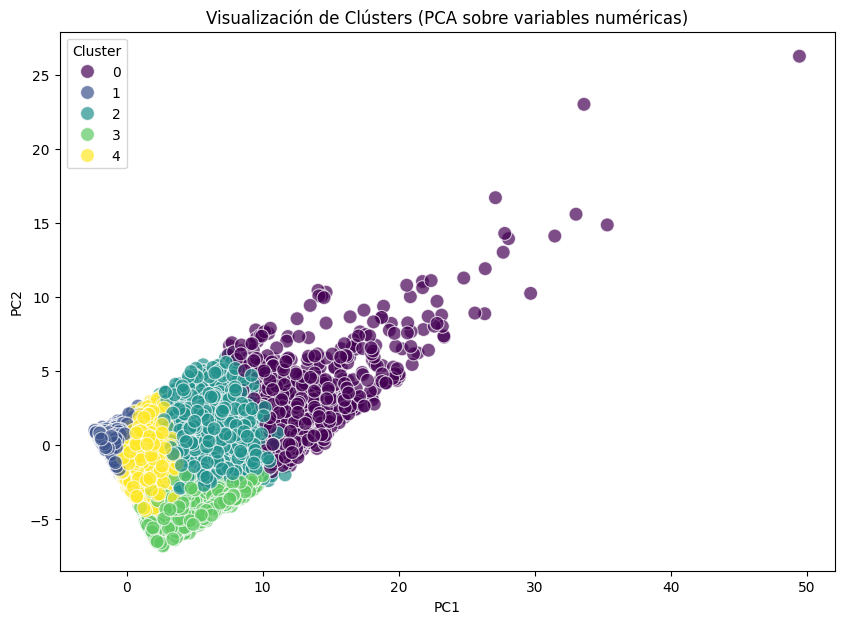

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns

# Nota: PCA solo funciona con números. Usaremos solo las columnas numéricas de X_prepared

X_numeric = X_prepared[:, :8]  

# Reducimos a 2 dimensiones
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_numeric)

# Creamos un DF temporal para graficar
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kprotype.labels_

# Graficamos
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', 
    hue='Cluster', palette='viridis', s=100, alpha=0.7
)
plt.title('Visualización de Clústers (PCA sobre variables numéricas)')
plt.show()

c:\Users\mauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\mauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\mauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\mauri\AppData\Local\Programs\Python\Python313\

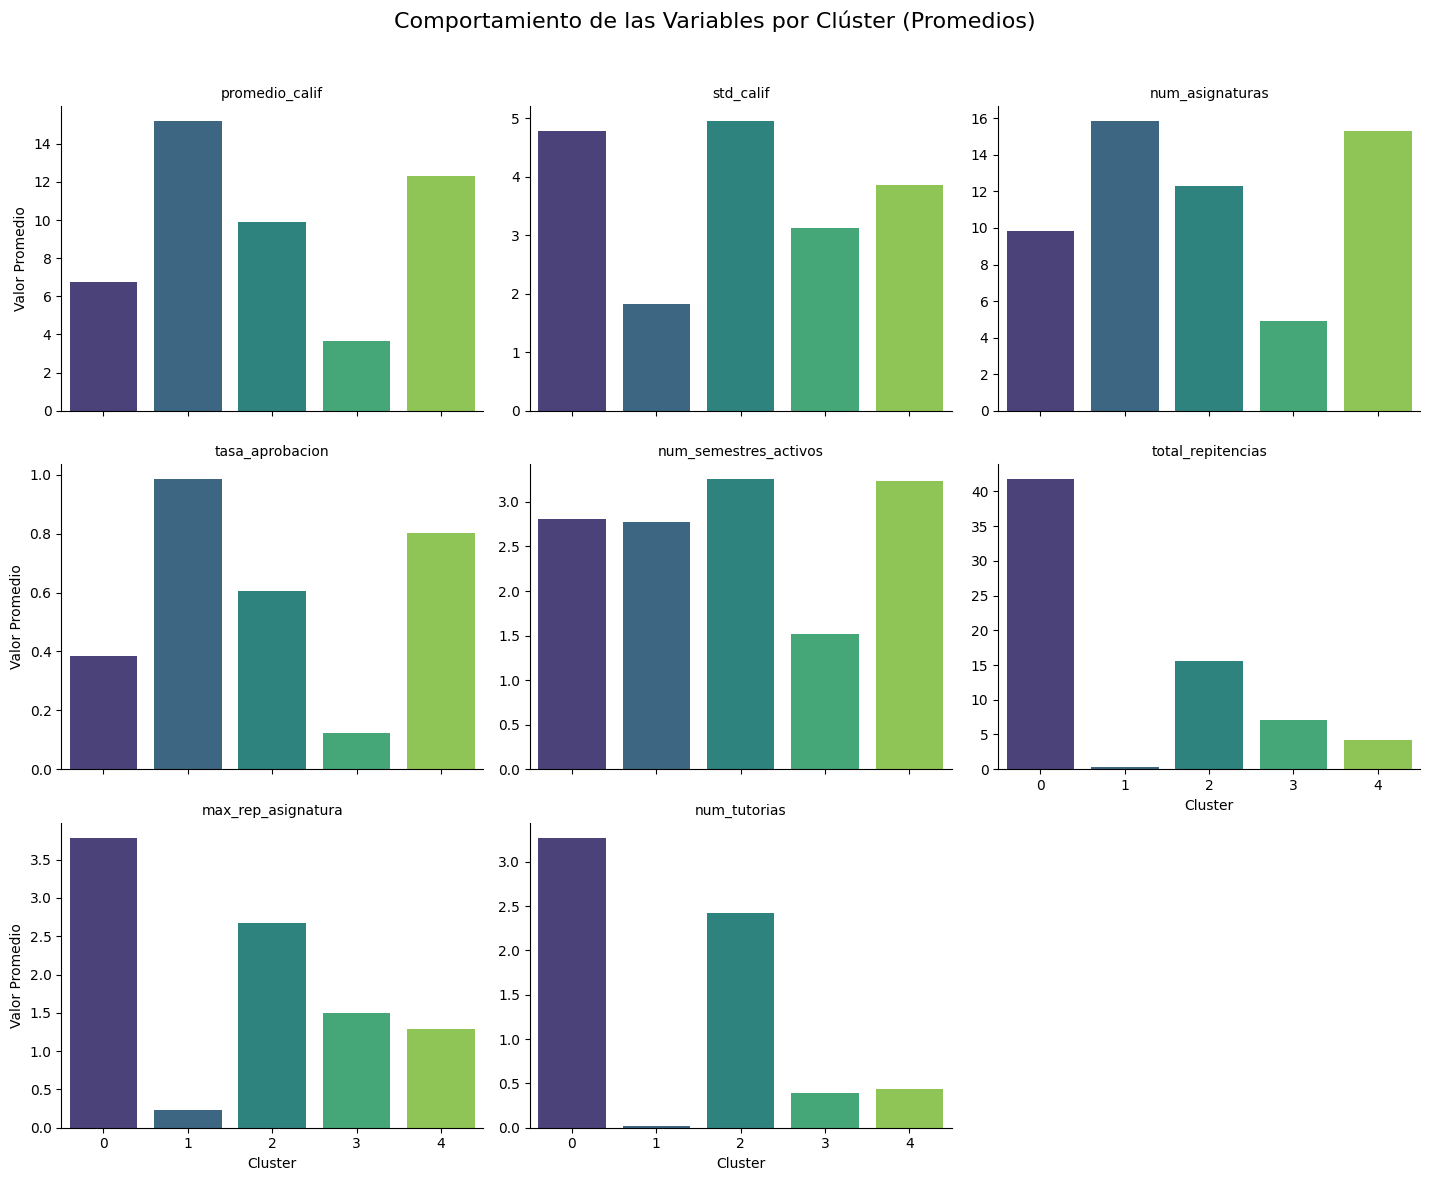

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


cluster_means = features_df.groupby('Cluster')[numeric_features].mean().reset_index()


df_melted = cluster_means.melt(id_vars="Cluster", var_name="Variable", value_name="Valor Promedio")


g = sns.FacetGrid(df_melted, col="Variable", col_wrap=3, sharey=False, height=4, aspect=1.2)
g.map(sns.barplot, "Cluster", "Valor Promedio", order=sorted(df_melted.Cluster.unique()), palette="viridis")

g.set_titles("{col_name}")  # Título
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Comportamiento de las Variables por Clúster (Promedios)', fontsize=16)
plt.show()

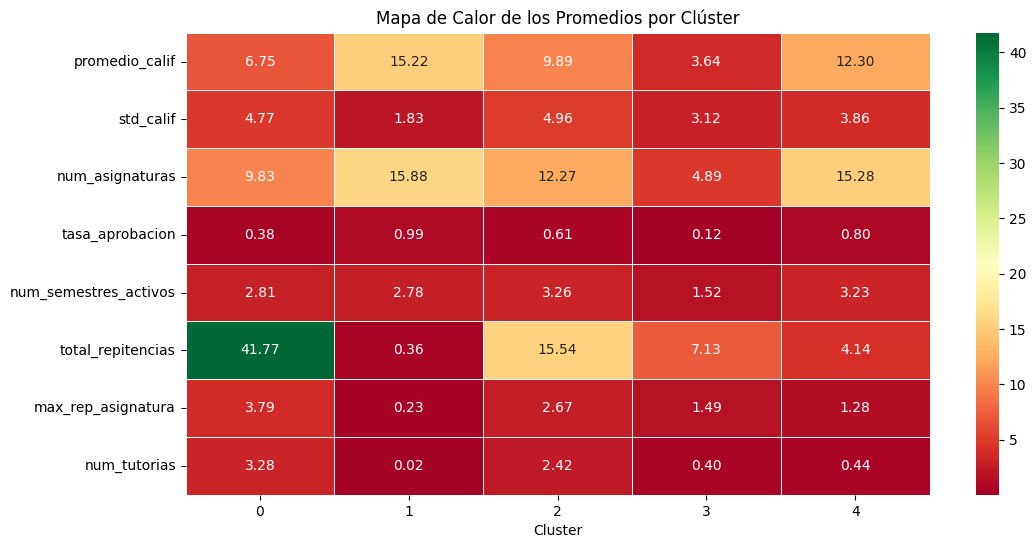

In [42]:
plt.figure(figsize=(12, 6))

sns.heatmap(cluster_means.set_index('Cluster').T, cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de los Promedios por Clúster')
plt.show()

# NUEVO ANALISIS

# Análisis de Clústeres Basado en Métricas Académicas

Este análisis interpreta los cinco clústeres generados mediante K-Means utilizando
las métricas agregadas por estudiante: promedio de calificaciones, desviación estándar,
número de tutorías y semestres activos.

Los valores utilizados corresponden a los promedios observados en el mapa de calor de los clústeres.

---

##  CLÚSTER 0 – Estudiantes con Alto Nivel de Repitencias y Bajo Desempeño

**Características principales:**
- **Promedio de calificaciones:** 6.75 (muy bajo)  
- **Desviación estándar:** 4.77 (alto nivel de variabilidad)  
- **Número de asignaturas:** 9.83  
- **Tasa de aprobación:** 0.38  
- **Total de repitencias:** 41.77 (extremadamente alto)  
- **Máx. repitencias por asignatura:** 3.79  
- **Tutorías recibidas:** 3.28  

**Interpretación:**  
Grupo con **desempeño académico muy deficiente**, caracterizado por un volumen extremo de repitencias y un rendimiento inestable. Son estudiantes con **alto riesgo académico**, que requieren intervención urgente.

---

##  CLÚSTER 1 – Estudiantes Excelentes y Estables

**Características principales:**
- **Promedio de calificaciones:** 15.22 (muy alto)  
- **Desviación estándar:** 1.83 (muy estable)  
- **Número de asignaturas:** 15.88 (el más alto)  
- **Tasa de aprobación:** 0.99  
- **Total de repitencias:** 0.36 (casi inexistente)  
- **Máx. repitencias por asignatura:** 0.23  
- **Tutorías recibidas:** 0.02  

**Interpretación:**  
El **mejor grupo del análisis**. Presentan un rendimiento sobresaliente, estabilidad en sus calificaciones, alta carga académica y prácticamente ninguna repitencia. Son estudiantes de **alto rendimiento**.

---

## CLÚSTER 2 – Estudiantes de Desempeño Moderado con Tendencia a Repitencias

**Características principales:**
- **Promedio de calificaciones:** 9.89  
- **Desviación estándar:** 4.96 (muy alta variabilidad)  
- **Número de asignaturas:** 12.27  
- **Tasa de aprobación:** 0.61  
- **Total de repitencias:** 15.54 (alto)  
- **Máx. repitencias por asignatura:** 2.67  
- **Tutorías recibidas:** 2.42  

**Interpretación:**  
Grupo con rendimiento **intermedio**, pero con una cantidad significativa de repitencias y desempeño inestable. Requieren seguimiento académico para mejorar su consistencia y progreso.

---

## CLÚSTER 3 – Estudiantes en Situación Académica Crítica

**Características principales:**
- **Promedio de calificaciones:** 3.64 (el más bajo)  
- **Desviación estándar:** 3.12  
- **Número de asignaturas:** 4.89 (muy bajo)  
- **Tasa de aprobación:** 0.12 (extremadamente baja)  
- **Total de repitencias:** 7.13  
- **Máx. repitencias por asignatura:** 1.49  
- **Tutorías recibidas:** 0.40  

**Interpretación:**  
Grupo con **desempeño crítico**, cursan pocas asignaturas, aprueban muy poco y, aun así, presentan repitencias. Representan el segmento más vulnerable del conjunto analizado y requieren una intervención prioritaria.

---

##  CLÚSTER 4 – Estudiantes Buenos y Consistentes

**Características principales:**
- **Promedio de calificaciones:** 12.30  
- **Desviación estándar:** 3.86  
- **Número de asignaturas:** 15.28 (alto)  
- **Tasa de aprobación:** 0.80  
- **Total de repitencias:** 4.14  
- **Máx. repitencias por asignatura:** 1.28  
- **Tutorías recibidas:** 0.44  

**Interpretación:**  
Grupo de **buen desempeño**, con una carga académica elevada, buen promedio y baja cantidad de repitencias. Son estudiantes constantes y responsables, con potencial de alto rendimiento.

---

# Resumen General

| Clúster | Perfil |
|--------|--------|
| **0** | Muy bajo rendimiento + repitencias extremadamente altas |
| **1** | Excelentes, alto rendimiento y estabilidad |
| **2** | Moderados con variabilidad y repitencias elevadas |
| **3** | Críticos, muy bajo rendimiento y pocas aprobaciones |
| **4** | Buenos estudiantes, constantes y con pocas repitencias |

---

# Conclusión

Los clústeres permiten identificar distintos perfiles académicos entre los estudiantes.  
Esta segmentación posibilita:

- Diseñar **intervenciones específicas** para cada grupo
- Priorizar apoyo académico para los clústeres **0 y 3**
- Potenciar el rendimiento de los clústeres **1 y 4**
- Monitorear la evolución del clúster **2**

Este análisis ofrece una visión clara del comportamiento académico y es un excelente insumo para planes de mejora institucional.
